In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import math
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import keras
from tensorflow import keras
from keras import Sequential
from keras import layers
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
PATH = 'Dataset'

def sample_bringer(path, target, num_samples=5):
    class_path = os.path.join(path, target)
    image_files = [image for image in os.listdir(class_path) if image.endswith('.jpg')]

    fig, ax = plt.subplots(1, num_samples, facecolor="gray")
    fig.suptitle(f'{target} Brain MRI Samples', color="yellow",fontsize=16, fontweight='bold', y=0.75)
    
    for i in range(num_samples):
        image_path = os.path.join(class_path, image_files[i])
        img = mpimg.imread(image_path)

        ax[i].imshow(img)
        ax[i].axis('off')
        ax[i].set_title(f'Sample {i+1}', color="aqua")

    plt.tight_layout()
    
data = tf.keras.utils.image_dataset_from_directory(PATH,
                                                batch_size = 32,
                                                image_size=(128, 128),
                                                shuffle=True,
                                                seed=42,)

class_names = data.class_names

Found 6400 files belonging to 4 classes.


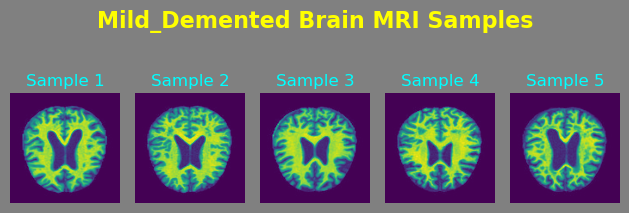

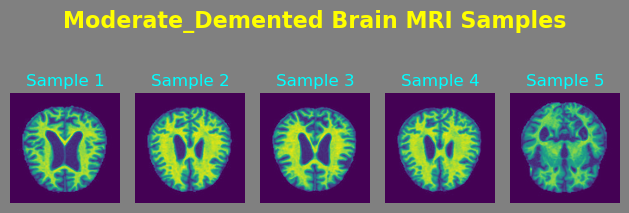

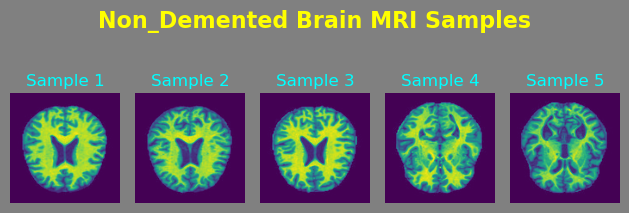

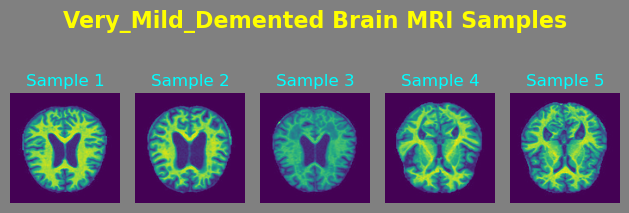

In [3]:
for target in class_names:
    sample_bringer(PATH, target=target)
    
alz_dict = {index: img for index, img in enumerate(data.class_names)}

Min and max pixel values in the batch -> 0.0 & 1.0


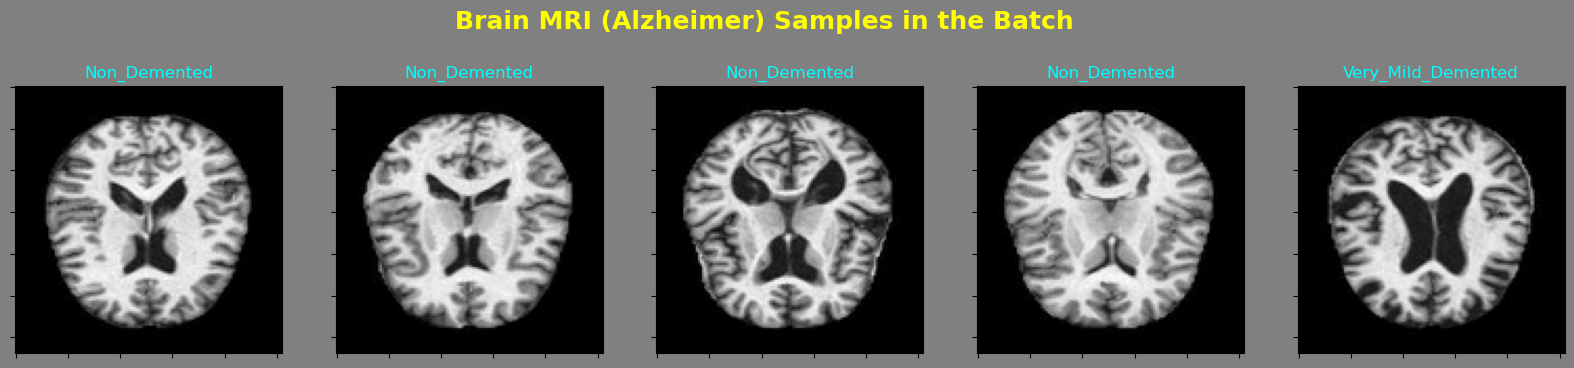

In [4]:
class Process:
    def __init__(self, data):
        self.data = data.map(lambda x, y: (x/255, y))

    def create_new_batch(self):
        self.batch = self.data.as_numpy_iterator().next()
        text = "Min and max pixel values in the batch ->"
        print(text, self.batch[0].min(), "&", self.batch[0].max())
        
    def show_batch_images(self, number_of_images=5):
        fig, ax = plt.subplots(ncols=number_of_images, figsize=(20,20), facecolor="gray")
        fig.suptitle("Brain MRI (Alzheimer) Samples in the Batch", color="yellow",fontsize=18, fontweight='bold', y=0.6)
        for idx, img in enumerate(self.batch[0][:number_of_images]):
            ax[idx].imshow(img)
            class_no = self.batch[1][idx]
            ax[idx].set_title(alz_dict[class_no], color="aqua")
            ax[idx].set_xticklabels([])
            ax[idx].set_yticklabels([])
    
    def train_test_val_split(self, train_size, val_size, test_size):
        train = int(len(self.data)*train_size)
        test = int(len(self.data)*test_size)
        val = int(len(self.data)*val_size)
        
        train_data = self.data.take(train)
        val_data = self.data.skip(train).take(val)
        test_data = self.data.skip(train+val).take(test)

        return train_data, val_data, test_data

process = Process(data)
process.create_new_batch()
process.show_batch_images(number_of_images=5)

train_data, val_data, test_data= process.train_test_val_split(train_size=0.8, val_size=0.1, test_size=0.1)


In [5]:
y_train = tf.concat(list(map(lambda x: x[1], train_data)), axis=0)
class_weight = compute_class_weight('balanced',classes=np.unique(y_train), y=y_train.numpy())
class_weights = dict(zip(np.unique(y_train), class_weight))

In [6]:
def checkpoint_callback():
    checkpoint_filepath = '/tmp/checkpoint.keras'
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=False,
        save_freq='epoch',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
    return model_checkpoint_callback

def early_stopping(patience=5):
    es_callback = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        verbose=1
    )
    return es_callback

In [7]:
def build_densenet_model():
    base_model = tf.keras.applications.DenseNet121(include_top=False, input_shape=(128, 128, 3), weights='imagenet')
    base_model.trainable = False 

    # Build the model
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(4, activation='softmax') 
    ])
    
    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Print model summary
    model.summary()
    
    return model 

In [8]:
def train_and_evaluate_model(model, train_data, val_data, class_weights, epochs=25):
    model_checkpoint = checkpoint_callback()
    early_stop = early_stopping()

    history = model.fit(
        train_data,
        epochs=epochs,
        validation_data=val_data,
        class_weight=class_weights,
        callbacks=[model_checkpoint, early_stop]
    )
    
    return history

In [10]:
densenet_model = build_densenet_model()
history = train_and_evaluate_model(densenet_model, train_data, val_data, class_weights, 50)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ ?                      │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,037,504 (26.85 MB)

Epoch 1/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 838ms/step - accuracy: 0.3438 - loss: 1.8269
Epoch 1: val_accuracy improved from -inf to 0.31563, saving model to /tmp/checkpoint.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.3440 - loss: 1.8247 - val_accuracy: 0.3156 - val_loss: 1.4663
Epoch 2/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 804ms/step - accuracy: 0.4436 - loss: 1.0665
Epoch 2: val_accuracy improved from 0.31563 to 0.45625, saving model to /tmp/checkpoint.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 148s 922ms/step - accuracy: 0.4438 - loss: 1.0666 - val_accuracy: 0.4563 - val_loss: 1.2141
Epoch 3/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 819ms/step - accuracy: 0.4914 - loss: 0.9577
Epoch 3: val_accuracy did not improve from 0.45625
160/160 ━━━━━━━━━━━━━━━━━━━━ 149s 931ms/step - accuracy: 0.4915 - loss: 0.9578 - val_accuracy: 0.3484 - val_loss: 1.4439
Epoch 4/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 780ms/step - accuracy: 0.5262 - loss: 0.9320
Epoch 4: val_accuracy improved from 0.45625 to 0.495

In [11]:
def random_mri_prob_bringer( model, image_number=0):
    
    for images, _ in test_data.skip(5).take(1):
        image = images[image_number]
        pred = model.predict(tf.expand_dims(image, 0))[0]
        
    probs = list(tf.nn.softmax(pred).numpy()) 
    probs_dict = dict(zip(class_dist.keys(), probs))
    
    keys = list(probs_dict.keys())
    values = list(probs_dict.values())

    fig, (ax1, ax2) = plt.subplots(1, 2, facecolor='black')
    plt.subplots_adjust(wspace=0.4) 
    ax1.imshow(image)
    ax1.set_title('Brain MRI', color="yellow", fontweight="bold", fontsize=16)
    
    edges = ['left', 'bottom', 'right', 'top']
    edge_color = "greenyellow"
    edge_width = 3
    for edge in edges:
        ax1.spines[edge].set_linewidth(edge_width)
        ax1.spines[edge].set_edgecolor(edge_color)

    plt.gca().axes.yaxis.set_ticklabels([])        
    plt.gca().axes.xaxis.set_ticklabels([])

    wedges, labels, autopct = ax2.pie(values, labels=keys,  autopct='%1.1f%%',
        shadow=True, startangle=90, colors=colors, textprops={'fontsize': 8, "fontweight":"bold", "color":"white"},  wedgeprops=
       {'edgecolor':'black'} , labeldistance=1.15)

    for autotext in autopct:
        autotext.set_color('black')

    ax2.set_title('Alzheimer Probabilities', color="yellow", fontweight="bold", fontsize=16)

predictions = []
labels = []

for X, y in test_data.as_numpy_iterator():
    y_pred = densenet_model.predict(X, verbose=0)
    y_prediction = np.argmax(y_pred, axis=1)
    predictions.extend(y_prediction)
    labels.extend(y)

predictions = np.array(predictions)
labels = np.array(labels)

print(classification_report(labels, predictions, target_names=class_names))

                    precision    recall  f1-score   support

     Mild_Demented       0.33      0.86      0.48        80
 Moderate_Demented       0.45      0.71      0.56         7
      Non_Demented       0.74      0.71      0.72       321
Very_Mild_Demented       0.68      0.33      0.45       232

          accuracy                           0.59       640
         macro avg       0.55      0.65      0.55       640
      weighted avg       0.66      0.59      0.59       640



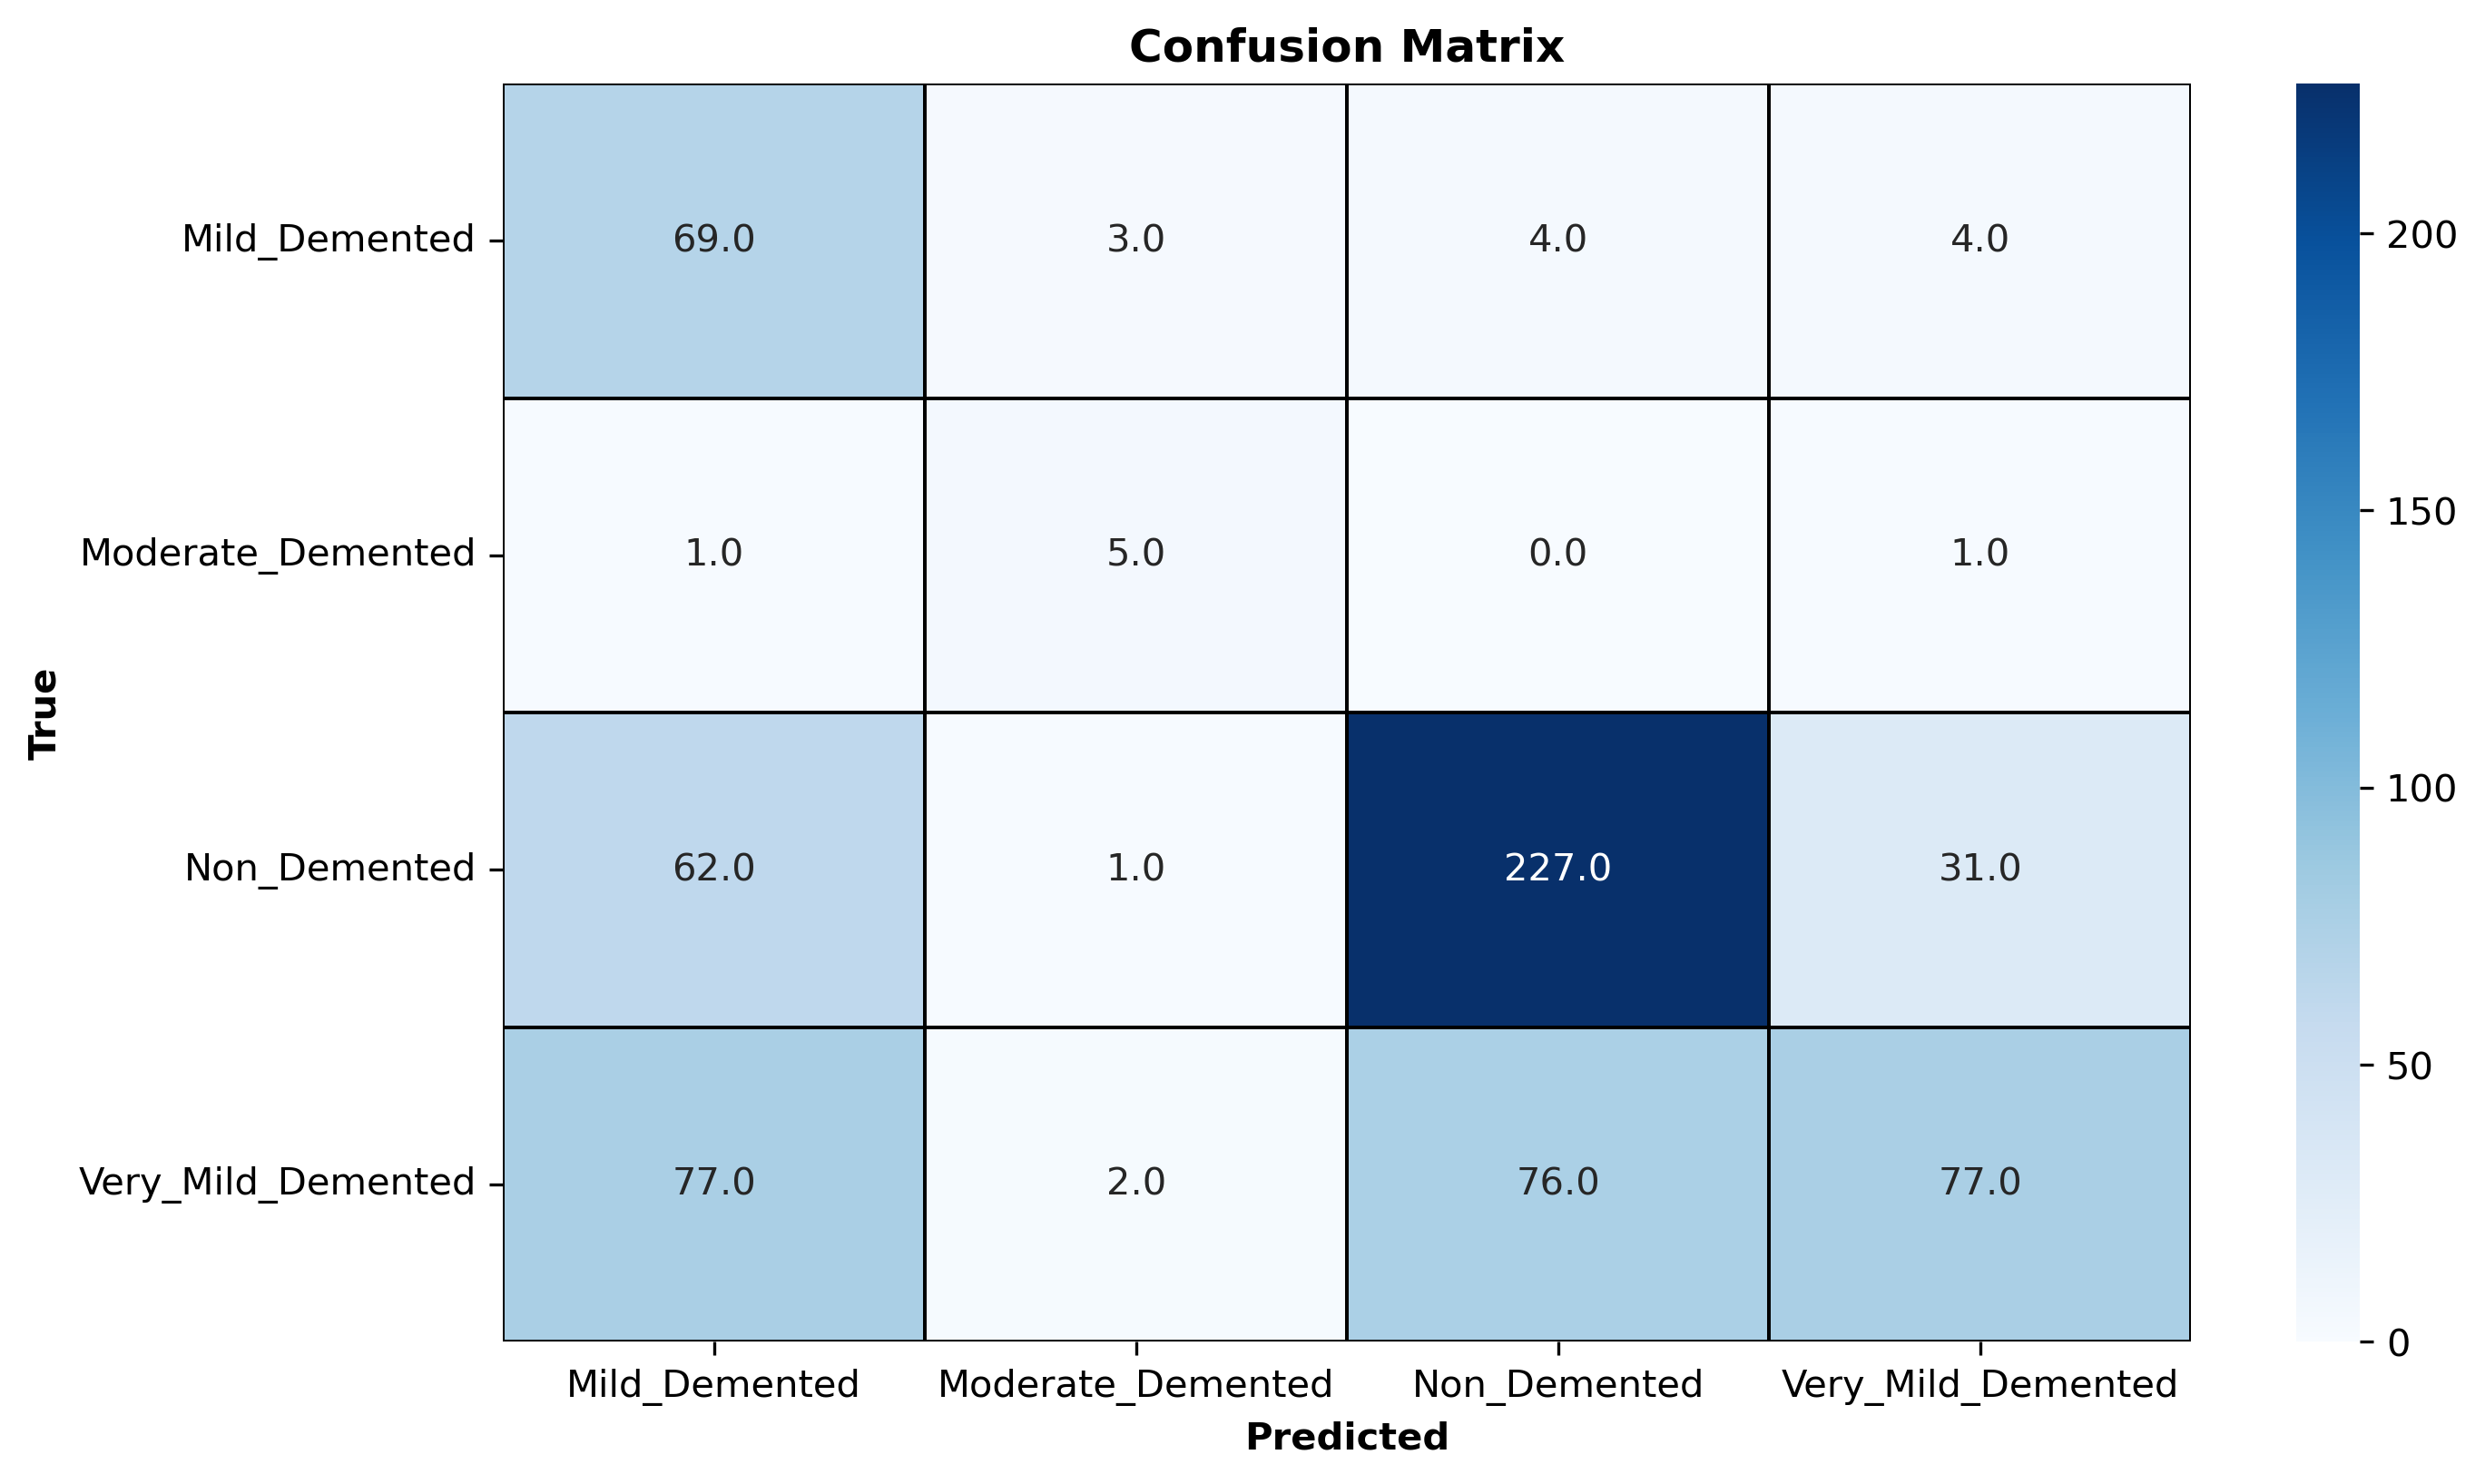

In [12]:
cm = confusion_matrix(labels, predictions)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(10,6), dpi=300)
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt=".1f", linewidths=0.5, linecolor='black')

plt.title("Confusion Matrix", fontweight="bold")
plt.xlabel("Predicted", fontweight="bold")
plt.ylabel("True", fontweight="bold")

plt.show()

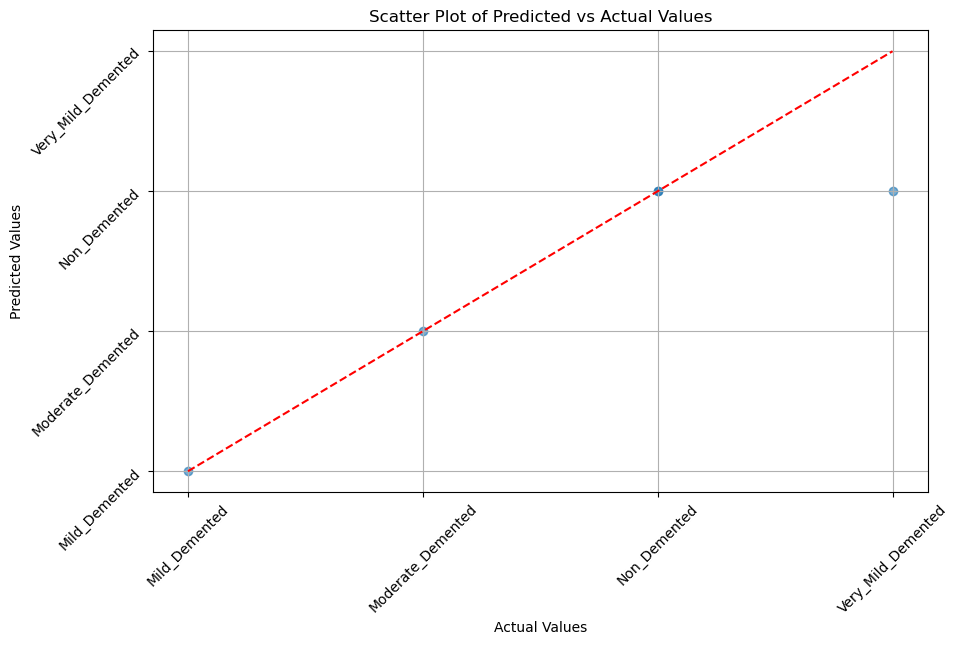

In [13]:
def plot_predicted_vs_actual(y_test, y_pred, class_names):
    # Convert labels to numerical indices
    y_test_indices = [class_names.index(label) for label in y_test]
    y_pred_indices = [class_names.index(label) for label in y_pred]
    
    plt.figure(figsize=(10, 6))
    
    # Scatter plot
    plt.scatter(y_test_indices, y_pred_indices, alpha=0.6)
    
    # Adding a line for perfect predictions
    plt.plot([min(y_test_indices), max(y_test_indices)], [min(y_test_indices), max(y_test_indices)], color='red', linestyle='--')
    
    # Labeling
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Scatter Plot of Predicted vs Actual Values')
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.yticks(range(len(class_names)), class_names, rotation=45)
    
    plt.grid(True)
    plt.show()

class_names = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']
y_test = ['Mild_Demented', 'Non_Demented', 'Very_Mild_Demented', 'Moderate_Demented', 'Non_Demented']
y_pred = ['Mild_Demented', 'Non_Demented', 'Non_Demented', 'Moderate_Demented', 'Non_Demented']
plot_predicted_vs_actual(y_test, y_pred, class_names)